In [11]:
import argparse
import glob
import json
import os
import random
import shutil
from pathlib import Path

import cv2
import nibabel as nib
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import umap
import matplotlib.pyplot as plt

In [17]:
# ==== 入出力パス ====
input_csv  = Path("/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/Sakaguchi_file/slice_train_sampling/axial/labels_axial.csv")
output_csv = Path("/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/Sakaguchi_file/slice_train_sampling/axial/sampling_labels_axial_2.csv")
output_dir = Path("/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/Sakaguchi_file/slice_train_sampling/axial/sampling_images_2")

# ==== ハイパーパラメータ ====
IMG_SIZE   = 128      # リサイズ後の一辺ピクセル数
N_SAMPLES  = 5000     # 抽出する正常スライス数
METHOD     = 'kmeans'   # 'grid' or 'kmeans'
SEED       = 42
PCA_DIMS   = 50


In [18]:
def load_slice(path: Path, img_size: int = 128):
    img = nib.load(str(path)).get_fdata()
    if img.ndim == 3:
        img = img[:, :, 0]
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32)
    img -= img.mean()
    img /= (img.std() + 1e-6)
    return img.flatten()

def embed_features(features: np.ndarray, pca_dims: int, seed: int):
    X = StandardScaler().fit_transform(features)
    if pca_dims and pca_dims < X.shape[1]:
        X = PCA(n_components=pca_dims, random_state=seed).fit_transform(X)
    return umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=seed).fit_transform(X)

def sample_grid(emb: np.ndarray, k: int, seed: int):
    rng = np.random.default_rng(seed)
    e_min, e_max = emb.min(0), emb.max(0)
    emb_n = (emb - e_min) / (e_max - e_min + 1e-9)
    g = int(np.ceil(np.sqrt(k)))
    grid = {}
    for idx, (x, y) in enumerate(emb_n):
        cell = (int(x * g), int(y * g))
        grid.setdefault(cell, []).append(idx)
    cells = list(grid.keys())
    rng.shuffle(cells)
    selected = []
    for cell in cells:
        idxs = grid[cell]
        rng.shuffle(idxs)
        selected.append(idxs[0])
        if len(selected) >= k:
            break
    return selected

def sample_kmeans(emb: np.ndarray, k: int, seed: int):
    km = KMeans(n_clusters=k, random_state=seed, n_init='auto').fit(emb)
    selected = []
    for c in range(k):
        members = np.where(km.labels_ == c)[0]
        if len(members):
            dists = np.linalg.norm(emb[members] - km.cluster_centers_[c], axis=1)
            selected.append(members[np.argmin(dists)])
    return selected

In [19]:
df = pd.read_csv(input_csv)

# 列名に合わせて設定
path_col   = 'FullPath'
label_col  = 'Fracture_Label'

normal_df = df[df[label_col] == 0].reset_index(drop=True)
print(f'Normal slices: {len(normal_df)}')

# --- 特徴量抽出 ---
features = [load_slice(Path(p), IMG_SIZE) for p in tqdm(normal_df[path_col], desc='Loading slices')]
features = np.stack(features)

# --- 埋め込み ---
emb = embed_features(features, PCA_DIMS, SEED)

# --- サンプリング ---
if METHOD == 'grid':
    selected_idx = sample_grid(emb, N_SAMPLES, SEED)
else:
    selected_idx = sample_kmeans(emb, N_SAMPLES, SEED)

selected_df = normal_df.iloc[selected_idx].copy()

# --- CSV 保存 ---
output_csv.parent.mkdir(parents=True, exist_ok=True)
selected_df.to_csv(output_csv, index=False)
print(f'Saved CSV to {output_csv}')

# --- 画像コピー ---
output_dir.mkdir(parents=True, exist_ok=True)
for src in tqdm(selected_df[path_col], desc='Copying images'):
    shutil.copy(src, output_dir / Path(src).name)
print(f'Copied images to {output_dir}')

Normal slices: 33142


Loading slices: 100%|██████████| 33142/33142 [00:54<00:00, 609.52it/s]
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Saved CSV to /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/Sakaguchi_file/slice_train_sampling/axial/sampling_labels_axial_2.csv


Copying images: 100%|██████████| 5000/5000 [00:16<00:00, 308.05it/s]

Copied images to /mnt/nfs1/home/yamamoto-hiroto/research/vertebrae/Sakaguchi_file/slice_train_sampling/axial/sampling_images_2


座標の意味

UMAP は 高次元の画素特徴量 を 2 次元に縮約したものです。

近くに描画されている点どうしは「元画像の見た目（濃度パターンなど）が似ている」、離れていれば異なる、と解釈できます。

軸の数値自体（‐10 〜 25 など）は相対的な位置関係を示すだけで、物理的な意味はありません。

色の意味

オレンジ = 正常クラスすべて

青 = サンプリング後に残した正常スライス

青点がオレンジの雲をまんべんなく覆っていれば、分布全体を代表するサンプルが取れたことになります。

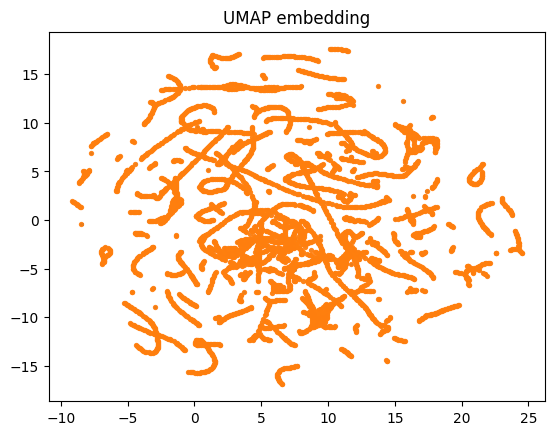

In [20]:
plt.scatter(emb[:,0], emb[:,1], s=1, alpha=0.3)
plt.scatter(emb[selected_idx,0], emb[selected_idx,1], s=8, alpha=0.9)
plt.title('UMAP embedding')
plt.show()

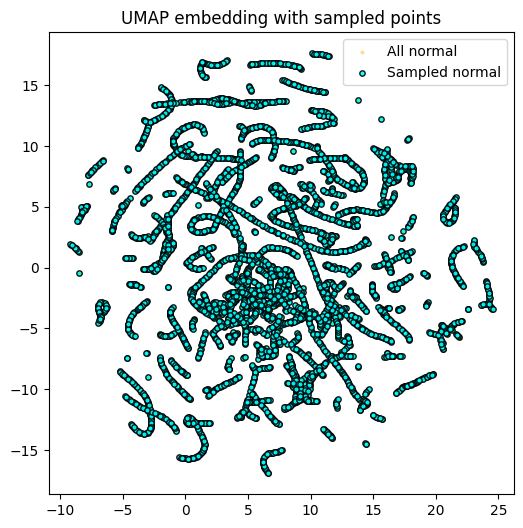

In [22]:
plt.figure(figsize=(6,6))
plt.scatter(emb[:,0], emb[:,1], s=4, alpha=0.3, label='All normal', color='orange')
plt.scatter(emb[selected_idx,0], emb[selected_idx,1],
            s=15, alpha=0.9, label='Sampled normal', edgecolor='k', facecolor='cyan')
plt.legend()
plt.title('UMAP embedding with sampled points')
plt.show()


In [21]:
df_all = pd.read_csv(input_csv)
print("Original  Positive =", (df_all['Fracture_Label'] == 1).sum())
print("Original  Negative =", (df_all['Fracture_Label'] == 0).sum())

df_sel = pd.read_csv(output_csv)
print("Sampled  Negative  =", len(df_sel))


Original  Positive = 4595
Original  Negative = 33142
Sampled  Negative  = 5000
